In [1]:
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
grid = pd.read_csv('Albedo_Models_Full_Resolution/withBad/Albedo_Models_Full_Resolution__NonDegenerate.csv')
grid = grid.iloc[:,len(grid.columns)-4:]
grid.head()

,[M/H],log g(cm_s2),T_eff(K),f_sed
0,0.0,2.0,150,1
1,0.0,2.0,150,10
2,0.0,2.0,150,2
3,0.0,2.0,150,3
4,0.0,2.0,150,4


In [2]:
grid.columns=['m','g','t','f']
grid.describe()

,m,g,t,f
count,11170.000000,11170.000000,11170.000000,11170.00000
mean,1.000895,3.057117,198.719785,5.50000
std,0.709350,0.604898,31.491831,2.87241
min,0.000000,2.000000,150.000000,1.00000
25%,0.500000,2.500000,170.000000,3.00000
50%,1.000000,3.100000,200.000000,5.50000
75%,1.500000,3.600000,220.000000,8.00000
max,2.000000,4.000000,270.000000,10.00000


In [3]:
def degen(values, counts, numModels, width, xlabel, showPercent=True):
    x = [v for v in values]
    y = [(counts[v] if v in counts else 0) for v in values]
    y2 = [numModels for v in values]
    print(y)
    plt.rcParams.update({'font.size': 20})
    plt.bar(x, y2, width=width, align='center', color='orange')
    plt.bar(x, y, width=width, align='center', color='blue')
    plt.xlabel(xlabel)
    plt.ylabel('Total Number of Models')
    #plt.title('Percent of non-degenerate Models')
    plt.legend(['Degenerate', 'Non-degenerate'], loc='best')

[2260, 2250, 2220, 2220, 2220]


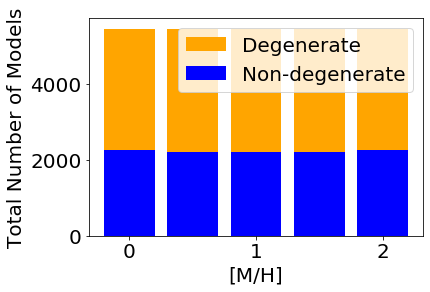

In [4]:
degen(grid.m.value_counts().index, grid.m.value_counts(), 5460, .4, '[M/H]', showPercent=False)

[630, 610, 600, 600, 580, 560, 550, 550, 550, 550, 530, 510, 500, 500, 500, 500, 500, 480, 460, 460, 450]


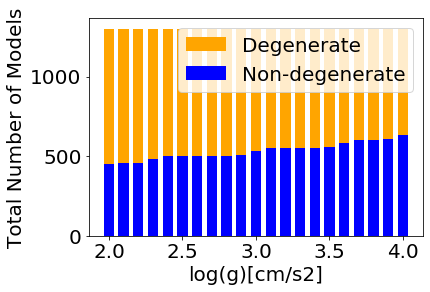

In [5]:
degen(grid.g.value_counts().index, grid.g.value_counts(), 1300, .07, 'log(g)[cm/s2]', showPercent=False)

[1050, 1050, 1050, 1050, 1050, 1050, 1050, 1050, 1050, 900, 540, 240, 40, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


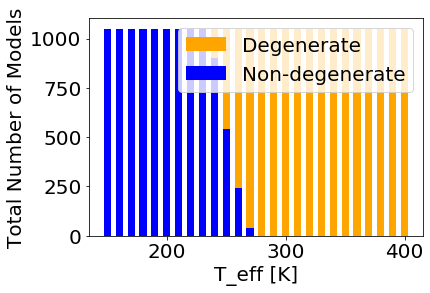

In [6]:
tValues = [150 + 10 * t for t in range(26)] # grid.t.value_counts().index
degen(tValues, grid.t.value_counts(), 1050, 6, 'T_eff [K]', showPercent=False)

[1117, 1117, 1117, 1117, 1117, 1117, 1117, 1117, 1117, 1117]


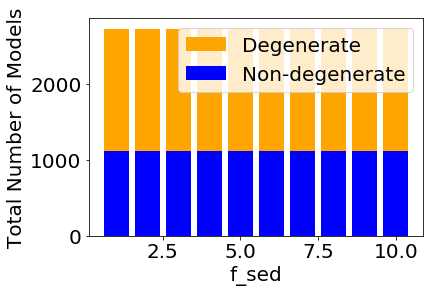

In [7]:
degen(grid.f.value_counts().index, grid.f.value_counts(), 2730, .8, 'f_sed', showPercent=False)

In [3]:
import pandas as pd
noises = ['No Noise', '5% Noise', '10% Noise', '20% Noise']
preds = {}
for noise in noises:
    preds[noise] = pd.read_csv("Albedo_Models_248Bins0.3to1.0microns/MLP_Results/" + noise + "/Test_Predictions.csv")
    preds[noise] = preds[noise].iloc[:,len(preds[noise].columns)-8:]
    preds[noise].columns = ['m_exp','m_est','g_exp','g_est','t_exp','t_est','f_exp','f_est']

In [35]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from sklearn.metrics import r2_score
from scipy.stats import kde

def scatterDist(c, noise):
    # Generate fake data
    x = preds[noise][c + '_exp']
    y = preds[noise][c + '_est']
    r2 = r2_score(x, y)
    plt.plot(x, x, color='black')

    xND = preds[noise].loc[preds[noise]['t_exp'] <= 230][c + '_exp']
    yND = preds[noise].loc[preds[noise]['t_exp'] <= 230][c + '_est']
    r2ND = r2_score(xND, yND)
    xD = preds[noise].loc[preds[noise]['t_exp'] > 230][c + '_exp']
    yD = preds[noise].loc[preds[noise]['t_exp'] > 230][c + '_est']
    r2D = r2_score(xD, yD)

    # Calculate and plot the point density
    for val in preds[noise][c + '_exp'].unique():
        x = preds[noise].loc[preds[noise][c + '_exp'] == val][c + '_exp']
        y = preds[noise].loc[preds[noise][c + '_exp'] == val][c + '_est']
        std = np.std(y)
        ave = np.mean(y)
        z = []
        for v in y:
            for i in range(4):
                if (v >= ave - (i+1)*std and v <= ave + (i+1)*std) or i is 3:
                    z.append(3-i)
                    break
        # sort it so the most dense are on top
        z2 = zip(z, y)
        z2 = sorted(z2)
        z = [a for a,b in z2]
        y = [b for a,b in z2]
        plt.scatter(x, y, c=z, s=60, edgecolor='')
    
    plt.rcParams.update({'font.size': 18})
    plt.scatter(x, y, c=z, s=60, edgecolor='')
    plt.plot(x, x, 'black')
    plt.text(.13, .815, f'R$^2$: {r2:.3f}   <240K: {r2ND:.3f}   >230K: {r2D:.3f}', fontsize=16, transform=plt.gcf().transFigure)
    if c is 'm':
        plt.title(r'[M/H] ' + noise, fontsize=20)
        plt.yticks([0.0, 0.5, 1.0, 1.5, 2.0, 2.5])
    if c is 'g':
        plt.title(r'log g(cm s$^{-2}$) ' + noise, fontsize=20)
        plt.yticks([2.0, 2.5, 3.0, 3.5, 4.0, 4.5])
    if c is 't':
        plt.title(r'$T_{eff}$ [K] ' + noise, fontsize=20)
        plt.yticks([150, 200, 250, 300, 350, 400, 450])
    if c is 'f':
        plt.title(r'$f_{sed}$ ' + noise, fontsize=20)
        plt.yticks([2, 4, 6, 8, 10, 13])
    plt.ylabel("Estimated Value", fontsize=20)
    plt.xlabel("Expected Value", fontsize=20)
    plt.show()

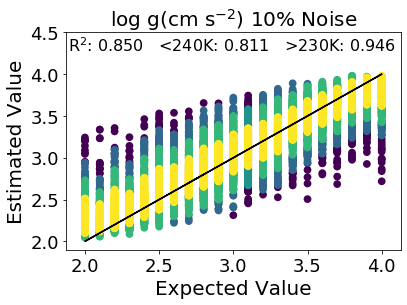

In [36]:
plt.

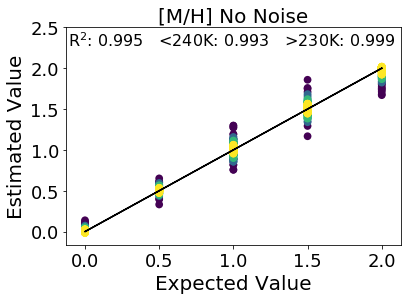

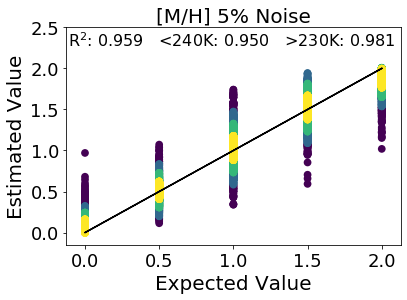

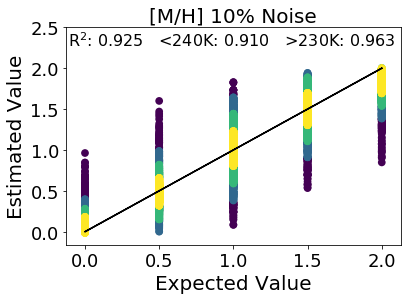

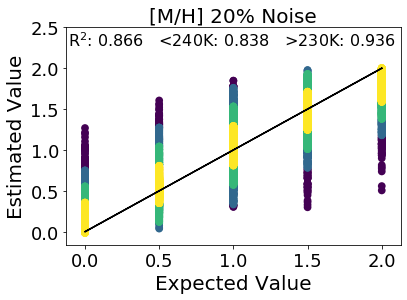

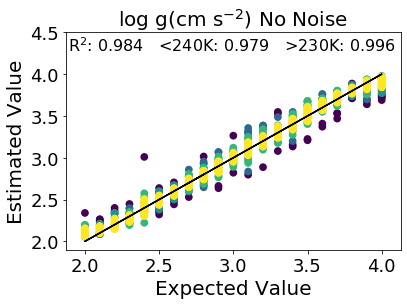

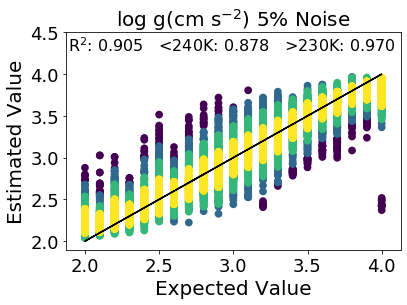

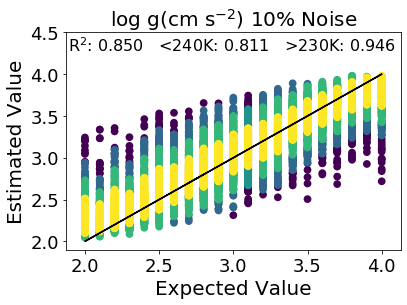

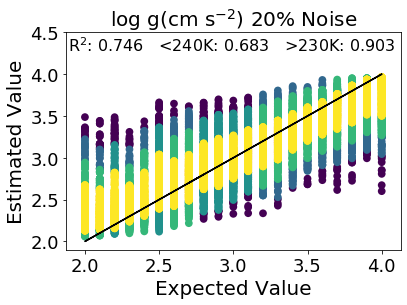

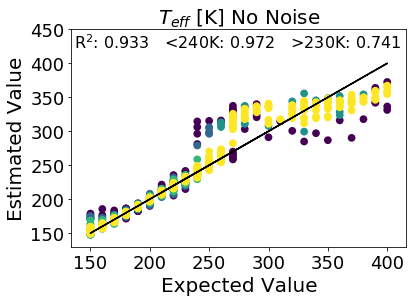

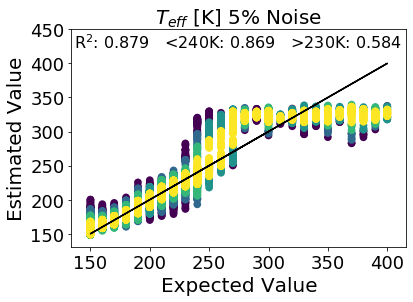

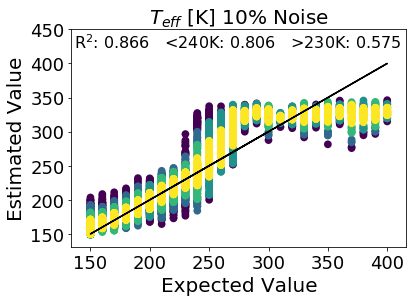

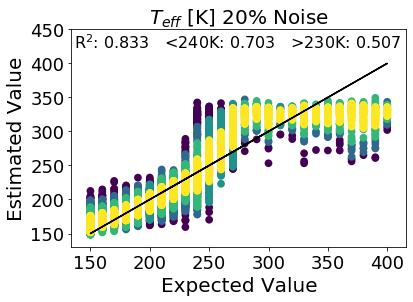

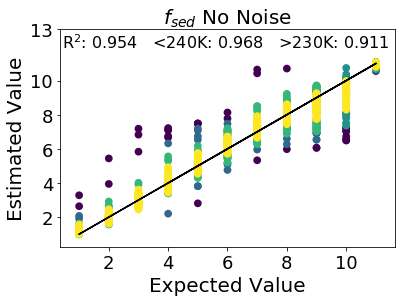

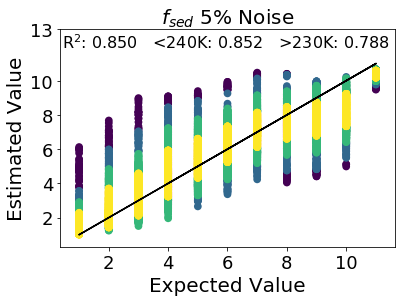

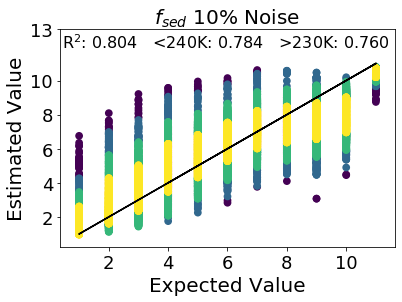

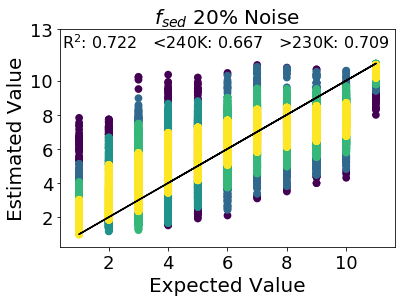

In [37]:
for c in ['m', 'g', 't', 'f']:
    for noise in noises:
        scatterDist(c, noise)

In [11]:
pred = pd.read_csv('Greedy0_Test_Predictions_0%.csv')
pred.head()

FileNotFoundError: [Errno 2] File b'Greedy0_Test_Predictions_0%.csv' does not exist: b'Greedy0_Test_Predictions_0%.csv'

In [ ]:
pred = pred.iloc[:,0:8]
pred.head()

In [ ]:
pred.columns = 'm_true','m_pred','g_true','g_pred','t_true','t_pred','f_true','f_pred'
pred.head()

In [ ]:
pred['m_err'] = abs(pred.m_pred-pred.m_true)
pred['g_err']  = abs(pred.g_pred-pred.g_true)
pred['t_err']  = abs(pred.t_pred-pred.t_true)
pred['f_err']  = abs(pred.f_pred-pred.f_true)
pred.head()

In [ ]:
pred.columns = '[M/H]','m_pred','log g(cm/s2)','g_pred','T_eff(K)','t_pred','f_sed','f_pred','m_err','g_err','t_err','f_err'
pred.head()

In [ ]:
fig, ax = plt.subplots(ncols=4, nrows=4)
fig.set_figheight(20)
fig.set_figwidth(20)
fig.suptitle('Heat Maps for Absolute Average Prediction Error in T_eff(K)', y=0.9, fontsize = 16)
truths = ['[M/H]', 'log g(cm/s2)', 'T_eff(K)', 'f_sed']

for i, t in enumerate(truths):
    for j, t2 in enumerate(truths):
        df = pred.groupby([t, t2]).mean()
        sns.heatmap(df.pivot_table(index=t, columns=t2, values='t_err'), ax=ax[i][j])

In [ ]:
fig, ax = plt.subplots(ncols=4, nrows=4)
fig.set_figheight(20)
fig.set_figwidth(20)
fig.suptitle('Heat Maps for Absolute Average Prediction Error in [M/H]', y=0.9, fontsize = 16)
truths = ['[M/H]', 'log g(cm/s2)', 'T_eff(K)', 'f_sed']

for i, t in enumerate(truths):
    for j, t2 in enumerate(truths):
        df = pred.groupby([t, t2]).mean()
        sns.heatmap(df.pivot_table(index=t, columns=t2, values='m_err'), ax=ax[i][j])

In [ ]:
fig, ax = plt.subplots(ncols=4, nrows=4)
fig.set_figheight(20)
fig.set_figwidth(20)
fig.suptitle('Heat Maps for Absolute Average Prediction Error in log g(cm/s2)', y=0.9, fontsize = 16)
truths = ['[M/H]', 'log g(cm/s2)', 'T_eff(K)', 'f_sed']

for i, t in enumerate(truths):
    for j, t2 in enumerate(truths):
        df = pred.groupby([t, t2]).mean()
        sns.heatmap(df.pivot_table(index=t, columns=t2, values='g_err'), ax=ax[i][j])

In [ ]:
fig, ax = plt.subplots(ncols=4, nrows=4)
fig.set_figheight(20)
fig.set_figwidth(20)
fig.suptitle('Heat Maps for Absolute Average Prediction Error in f_sed', y=0.9, fontsize = 16)
truths = ['[M/H]', 'log g(cm/s2)', 'T_eff(K)', 'f_sed']

for i, t in enumerate(truths):
    for j, t2 in enumerate(truths):
        df = pred.groupby([t, t2]).mean()
        sns.heatmap(df.pivot_table(index=t, columns=t2, values='f_err'), ax=ax[i][j])